In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from scipy.io import loadmat
import numpy as np
import re
from xml.etree import ElementTree as ET
from matplotlib.path import Path


### We mask the inshore upwelling

In [2]:
## Functions
## kml to struct
def kml2struct(kml_file):
    """
    Import a .kml file as a list of dictionary structures with fields:
    Geometry, Name, Description, Lon, Lat, and BoundingBox.
    """
    # Read the KML file
    try:
        with open(kml_file, 'r', encoding='utf-8') as file:
            txt = file.read()
    except Exception as e:
        raise FileNotFoundError(f"Unable to open file {kml_file}: {e}")

    # Regular expression to match Placemark tags
    expr = r"<Placemark.+?>.+?</Placemark>"
    object_strings = re.findall(expr, txt, re.DOTALL)
    
    kml_struct = []

    for obj_str in object_strings:
        # Extract Name
        name_match = re.search(r"<name.*?>(.*?)</name>", obj_str, re.DOTALL)
        name = name_match.group(1).strip() if name_match else "undefined"

        # Extract Description
        desc_match = re.search(r"<description.*?>(.*?)</description>", obj_str, re.DOTALL)
        desc = desc_match.group(1).strip() if desc_match else ""

        # Determine Geometry Type
        geometry = ""
        if "<Point" in obj_str:
            geometry = "Point"
        elif "<LineString" in obj_str:
            geometry = "Line"
        elif "<Polygon" in obj_str:
            geometry = "Polygon"

        # Extract Coordinates
        coord_match = re.search(r"<coordinates.*?>(.*?)</coordinates>", obj_str, re.DOTALL)
        if not coord_match:
            continue  # Skip if no coordinates are found
        coord_str = coord_match.group(1).strip()
        coord_list = np.array([list(map(float, coord.split(','))) for coord in coord_str.split()])

        # Separate Lon, Lat, and handle Polygons
        lon = coord_list[:, 0]
        lat = coord_list[:, 1]
        if geometry == "Polygon":
            # Close the polygon by appending NaN
            lon = np.append(lon, np.nan)
            lat = np.append(lat, np.nan)

        # Create BoundingBox
        bounding_box = [[lon.min(), lat.min()], [lon.max(), lat.max()]]

        # Append to kml_struct
        kml_struct.append({
            "Geometry": geometry,
            "Name": name,
            "Description": desc,
            "Lon": lon,
            "Lat": lat,
            "BoundingBox": bounding_box
        })

    return kml_struct

In [3]:
# Load the KML file to get the polygon boundary
arch_kml_zona1 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK150km.kml"
R1 = kml2struct(arch_kml_zona1)

# Extract Lon and Lat from the first polygon
lonb1 = R1[0]["Lon"]
latb1 = R1[0]["Lat"]

## Lon and lat for the whole dataset
lat = np.linspace(-33.0, 10.03286, 542).reshape(542, 1)  # Reshape to match eta_rho
lon = np.linspace(-118.9083, -68.90833, 602).reshape(1, 602)  # Reshape to match xi_rho

lats, lons = np.meshgrid(lat.flatten(), lon.flatten(), indexing="ij")

LON=lons
LAT=lats
# Create a path from the polygon coordinates
polygon = Path(np.column_stack((lonb1, latb1)))

# Flatten the LON and LAT to create coordinate pairs
lonlat_points = np.column_stack((LON.ravel(), LAT.ravel()))

# Check which points are inside the polygon
mask = polygon.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
inshore_mask = np.where(mask, 1, np.nan)

### Load the Indices

In [4]:
## Load lat from SST
ds_temp = xr.open_dataset('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/data/avg_Y1990M01.nc',
                            chunks = {'time':1}).temp.isel(s_rho=-1)
ds_temp.lat_rho.values

array([[-33.      , -33.      , -33.      , ..., -33.      , -33.      ,
        -33.      ],
       [-32.93011 , -32.93011 , -32.93011 , ..., -32.93011 , -32.93011 ,
        -32.93011 ],
       [-32.860165, -32.860165, -32.860165, ..., -32.860165, -32.860165,
        -32.860165],
       ...,
       [  9.868679,   9.868679,   9.868679, ...,   9.868679,   9.868679,
          9.868679],
       [  9.950779,   9.950779,   9.950779, ...,   9.950779,   9.950779,
          9.950779],
       [ 10.032859,  10.032859,  10.032859, ...,  10.032859,  10.032859,
         10.032859]], dtype=float32)

In [6]:
CUI_MAX = xr.open_dataset('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/CUI_maxi_dataset_abs.nc',
                            )
CUI_MAX

<xarray.Dataset> Size: 273kB
Dimensions:   (time: 252, lat: 134)
Coordinates:
  * time      (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile  float64 8B ...
  * lat       (lat) float32 536B -15.95 -15.87 -15.79 ... -5.242 -5.159 -5.076
Data variables:
    CUI_max   (time, lat) float64 270kB ...

In [7]:
CUI_old = loadmat("../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/CUI_SST_index.mat")
mean_cui = np.array(CUI_old['CUI_SSTi']).squeeze()
lati = np.array(CUI_old['lati']).squeeze()
#print(lati)
print(mean_cui.shape)


(185, 252)


In [8]:
# Convert `CUI_old` data into a DataArray
CUI_old_ts = xr.DataArray(
    data=mean_cui.T,  # numpy array of Mean_CUI
    dims=["time",'lat'],  # Dimension matches the time in CUI_MAX
    coords={"time": CUI_MAX["time"].values,
           'lat': lati},  # Ensure matching time coordinates
    name="CUI_old"  # Name for the variable
)

# # Add `CUI_old` as a new variable to the dataset
CUI_MAX['CUI_old']=CUI_old_ts.where((CUI_old_ts.lat >= -16) & (CUI_old_ts.lat<-5),drop=True)
CUI_MAX

<xarray.Dataset> Size: 543kB
Dimensions:   (time: 252, lat: 134)
Coordinates:
  * time      (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile  float64 8B ...
  * lat       (lat) float64 1kB -15.95 -15.87 -15.79 ... -5.242 -5.159 -5.076
Data variables:
    CUI_max   (time, lat) float64 270kB ...
    CUI_old   (time, lat) float64 270kB 0.4255 0.489 0.3985 ... 0.9483 0.6926

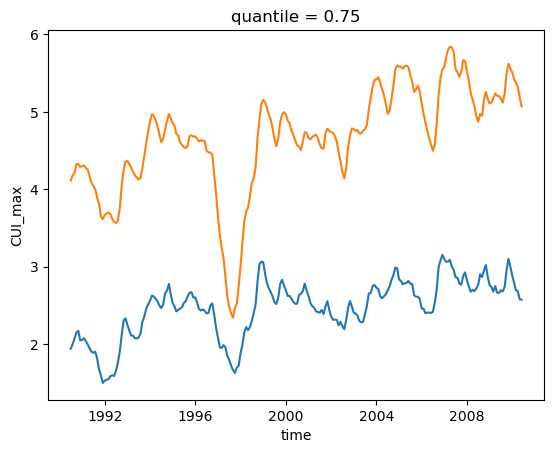

In [9]:
CUI_MAX.CUI_old.mean(dim='lat').rolling(time=13,center=True).mean().plot()
CUI_MAX.CUI_max.mean(dim='lat').rolling(time=13,center=True).mean().plot()

In [10]:
## EKMAN
Ekman_data = loadmat("../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/EKMAN_pump_April.mat")
Ek_pump = Ekman_data['EK_pump']
#V_wind = Ekman_data['VEK']
Ek_pump.shape #lon, lat, time

(602, 542, 252)

In [11]:

EK_t=Ek_pump.transpose(2, 1, 0)

latt=ds_temp.lat_rho.values[:,0]
latt.shape

(542,)

In [12]:
EK_ds = xr.Dataset(
    data_vars={
        'Ekman_pump': (("time", "lat","lon"), Ek_pump.transpose(2, 1, 0)),
    },
    coords = {
        'lat':latt,
        'lon':lon.flatten(),
        'time':CUI_MAX.time
}
)

EK_ds

<xarray.Dataset> Size: 658MB
Dimensions:     (time: 252, lat: 542, lon: 602)
Coordinates:
  * time        (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile    float64 8B ...
  * lat         (lat) float32 2kB -33.0 -32.93 -32.86 ... 9.869 9.951 10.03
  * lon         (lon) float64 5kB -118.9 -118.8 -118.7 ... -69.07 -68.99 -68.91
Data variables:
    Ekman_pump  (time, lat, lon) float64 658MB -9.628e-07 -1.056e-06 ... nan nan

In [13]:
## get the mask of the EKman pump
Pump_inshore = EK_ds['Ekman_pump'] * inshore_mask
#Pump_inshore.sel(time='1990-01-01').plot()

In [14]:
#Pump_inshore.where((Pump_inshore.lat >= -16) & (Pump_inshore.lat<-5),drop=True)
Pump_inshore=Pump_inshore.where((Pump_inshore.lat >= -16) & (Pump_inshore.lat <= -5) & 
                  (Pump_inshore.lon >= -90) & (Pump_inshore.lon <= -65), drop=True)
Pump_inshore

<xarray.DataArray 'Ekman_pump' (time: 252, lat: 134, lon: 254)> Size: 69MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time      (time) datetime64[ns] 2kB 1990-01-01 1990-02-01 ... 2010-12-01
    quantile  float64 8B 0.75
  * lat       (lat) float32 536B -15.95 -15.87 -15.79 ... -5.242 -5.159 -5.076
  * lon       (lon) float64 2kB -89.96 -89.87 -89.79 ... -69.07 -68.99 -68.91

### Calculate correlations

In [15]:
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

# Normalize each rolled mean
#CUI_7_5_norm = normalize(CUI_7_5)
Pumpi = Pump_inshore.mean(dim=('lat','lon')).rolling(time=13,center=True).mean()
CUI_oldi= normalize(CUI_MAX.CUI_old.mean(dim='lat').rolling(time=13,center=True).mean())
CUI_maxi = normalize(CUI_MAX.CUI_max.mean(dim='lat').rolling(time=13,center=True).mean())

Pump_normal = normalize(Pumpi)
CUI_max_normal= normalize(CUI_maxi)
CUI_old_normal = normalize(CUI_oldi)

# Create the plot
# fig, ax = plt.subplots(figsize=(10, 6))

# Pump_normal.plot()
# CUI_max_normal.plot()
# CUI_old_normal.plot()
# plt.grid()

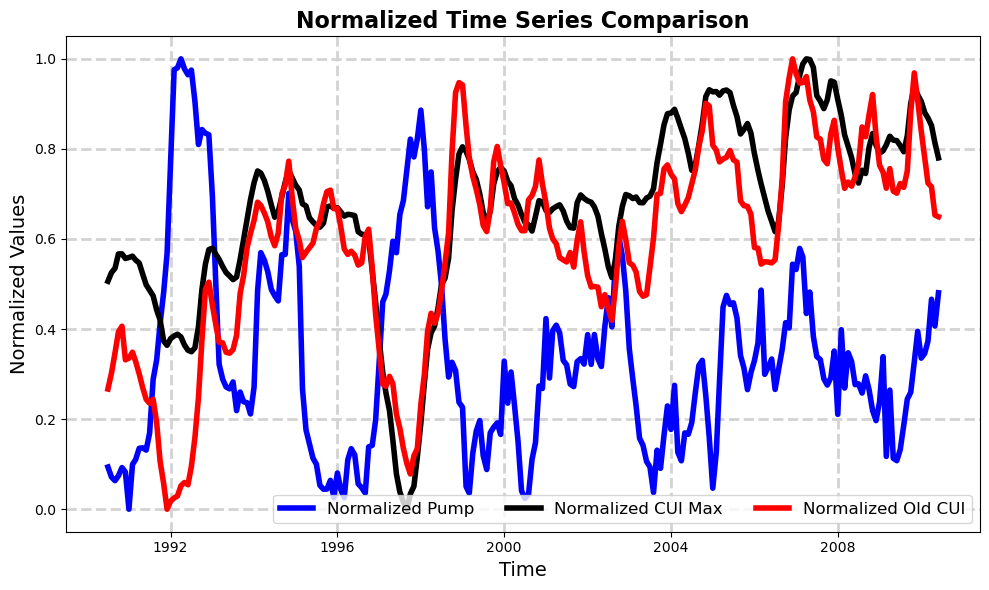

In [16]:
# Plot the normalized data with improved aesthetics
plt.figure(figsize=(10, 6))

# Plot each normalized variable with distinct colors and line styles
Pump_normal.plot(color="blue", linewidth=4, label="Normalized Pump")
CUI_max_normal.plot(color="black", linewidth=4, label="Normalized CUI Max")
CUI_old_normal.plot(color="red", linewidth=4, label="Normalized Old CUI")

# Add title, labels, grid, and legend
plt.title("Normalized Time Series Comparison", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Normalized Values", fontsize=14)
plt.grid(color="lightgrey", linestyle="--", linewidth=2, alpha=1)
plt.legend(fontsize=12, loc="lower right", title_fontsize=12, ncol=3, frameon=True)

# Tight layout for better spacing
plt.tight_layout()

# plt.savefig('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/CUI_PUMP_compare.png',format='png', 
#             dpi=300, transparent=True,bbox_inches='tight')

# Display the plot
plt.show()


In [17]:
## Now lag both according to the Ekman pump
print(xr.corr(CUI_max_normal, Pump_normal, dim="time"))
print(xr.corr(CUI_old_normal, Pump_normal, dim="time"))

<xarray.DataArray ()> Size: 8B
array(-0.42616197)
Coordinates:
    quantile  float64 8B 0.75
<xarray.DataArray ()> Size: 8B
array(-0.41214744)
Coordinates:
    quantile  float64 8B 0.75


In [18]:

lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = CUI_max_normal.shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pump_normal, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags
# # Plot the correlations for each lag
# ssta_ekpump_corr_lags.plot(
#     x="lon",
#     y="lat",
#     col="lag",
#     col_wrap=3,  # Adjust the layout of the plots
#     cmap=cm.balance,  # Color map
#     aspect=1.5,  # Adjust aspect ratio
#     subplot_kws={"title": "Lag: {value} month(s)"}
# )

# plt.show()


<xarray.DataArray (lag: 6)> Size: 48B
array([-0.40509766, -0.38005298, -0.35284267, -0.31873114, -0.27570727,
       -0.22561824])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

In [19]:
lags = range(1, 7)  # 1 to 6 months
corr_lags = []

for lag in lags:
    # # Shift the SST anomalies by 1 month (forward in time)
    ssta_lagged = CUI_old_normal.shift(time=-lag)
    
    # Compute the correlation for the current lag
    corr = xr.corr(ssta_lagged, Pump_normal, dim="time")
    
    # Add a new dimension for the lag
    corr = corr.expand_dims(lag=[lag])
    corr_lags.append(corr)

# Concatenate all correlations along the new "lag" dimension
ssta_ekpump_corr_lags = xr.concat(corr_lags, dim="lag")

ssta_ekpump_corr_lags

<xarray.DataArray (lag: 6)> Size: 48B
array([-0.39887036, -0.3767145 , -0.34833033, -0.30802491, -0.25584778,
       -0.19511203])
Coordinates:
  * lag       (lag) int64 48B 1 2 3 4 5 6
    quantile  float64 8B 0.75

### Latitudinal correlation

In [20]:
Pumpi_lat = Pump_inshore.mean(dim=('time','lon')).rolling(lat=13,center=True).mean()
CUI_oldi_lat= CUI_MAX.CUI_old.mean(dim='time').rolling(lat=13,center=True).mean()
CUI_maxi_lat = CUI_MAX.CUI_max.mean(dim='time').rolling(lat=13,center=True).mean()

Pump_normal_la = normalize(Pumpi_lat)
CUI_max_normal_la = normalize(CUI_maxi_lat)
CUI_old_normal_la = normalize(CUI_oldi_lat)


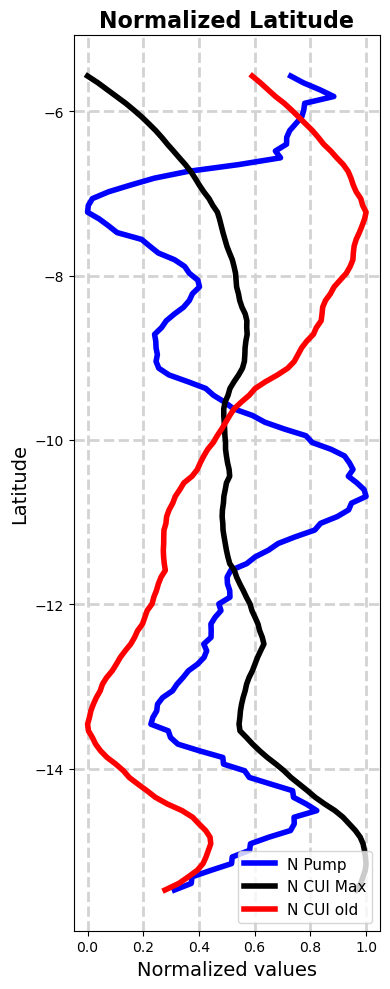

In [21]:
# Plot the normalized data with improved aesthetics
plt.figure(figsize=(4, 10))

# Plot each normalized variable with distinct colors and line styles
Pump_normal_la.plot(y='lat',color="blue", linewidth=4, label="N Pump")
CUI_max_normal_la.plot(y='lat',color="black", linewidth=4, label="N CUI Max")
CUI_old_normal_la.plot(y='lat',color="red", linewidth=4, label="N CUI old")

# Add title, labels, grid, and legend
plt.title("Normalized Latitude", fontsize=16, fontweight="bold")
plt.xlabel("Normalized values", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(color="lightgrey", linestyle="--", linewidth=2, alpha=1)
plt.legend(fontsize=11, loc="lower right", title_fontsize=12, ncol=1, frameon=True)

# Tight layout for better spacing
plt.tight_layout()

# plt.savefig('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/CUI_PUMP_compare_lat.png',format='png', 
#             dpi=300, transparent=True,bbox_inches='tight')

# Display the plot
plt.show()


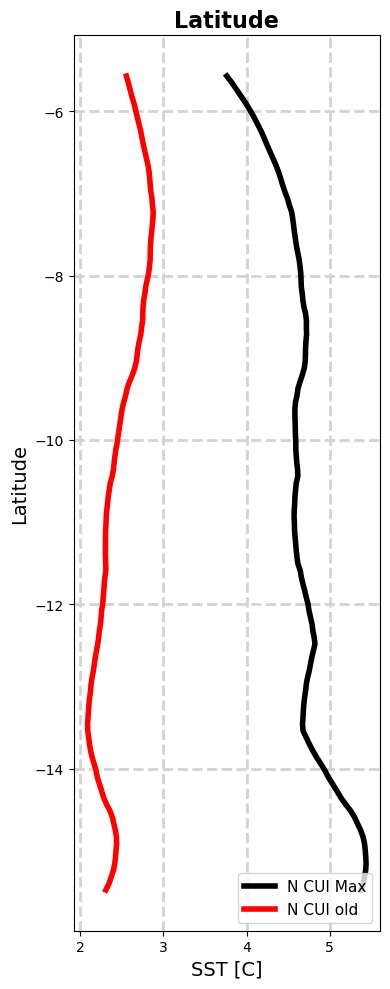

In [23]:
plt.figure(figsize=(4, 10))

# Plot each normalized variable with distinct colors and line styles
#Pump_normal_la.plot(y='lat',color="blue", linewidth=4, label="N Pump")
CUI_MAX.CUI_max.mean(dim='time').rolling(lat=13,center=True).mean().plot(y='lat',color="black", linewidth=4, label="N CUI Max")
CUI_MAX.CUI_old.mean(dim='time').rolling(lat=13,center=True).mean().plot(y='lat',color="red", linewidth=4, label="N CUI old")

# Add title, labels, grid, and legend
plt.title("Latitude", fontsize=16, fontweight="bold")
plt.xlabel("SST [C]", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.grid(color="lightgrey", linestyle="--", linewidth=2, alpha=1)
plt.legend(fontsize=11, loc="lower right", title_fontsize=12, ncol=1, frameon=True)

# Tight layout for better spacing
plt.tight_layout()

# plt.savefig('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/CUI_PUMP_compare_lat.png',format='png', 
#             dpi=300, transparent=True,bbox_inches='tight')

# Display the plot
plt.show()

In [24]:
print(Pump_normal_la.data.shape)
print(CUI_max_normal_la.data.shape)

(134,)
(134,)


In [25]:
cuimax=CUI_MAX.CUI_max.mean(dim='time').rolling(lat=13,center=True).mean()
cuiold=CUI_MAX.CUI_old.mean(dim='time').rolling(lat=13,center=True).mean()
cuimax
import pandas as pd
# Convert xarray objects to pandas DataFrame
df = pd.DataFrame({
    'CUI_max': cuimax.data,
    'Pump': Pumpi_lat.data
})
#print(*df["CUI_max"])
# # Drop rows with NaN values
df_clean = df.dropna()

# # Compute the correlation
correlation = df_clean['CUI_max'].corr(df_clean['Pump'])
print("Correlation between CUI_max and Pump:", correlation)

df_clean

Correlation between CUI_max and Pump: -0.11973742367375503


,CUI_max,Pump
6,5.376270,0.000011
7,5.403778,0.000011
8,5.417558,0.000011
9,5.430652,0.000011
10,5.435411,0.000011
...,...,...
123,3.991917,0.000013
124,3.936733,0.000013
125,3.881378,0.000013
126,3.825434,0.000013


In [26]:
# # Similarly for the old CUI
df_old = pd.DataFrame({
    'CUI_old': cuiold.data,
    'Pump': Pumpi_lat.data
})

# Drop rows with NaN values
df_old_clean = df_old.dropna()

# # Compute the correlation
correlation = df_old_clean['CUI_old'].corr(df_clean['Pump'])
print("Correlation between CUI_old and Pump:", correlation)


Correlation between CUI_old and Pump: -0.2653133333427118
